In [38]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [39]:
# img import 및 그레이스케일 화
img = cv2.imread('img/20230516182409_00001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, (3, 3), 0)

In [40]:
# 색상 반전
# invert = img.copy()
# invert = 255 - invert
# invert.size

In [41]:
# 넓이 반환 함수
def getArea(x, y, w, h):
    return {x: x, y: y, area: x * y, w: w, h: h}

(2335, 1651)


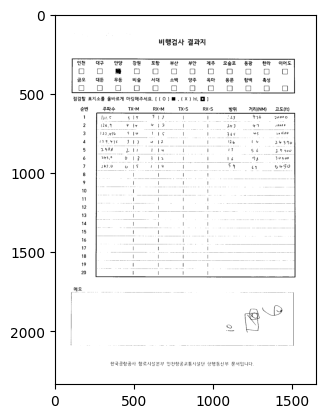

In [42]:
# 임계값 지정
ret, thresh = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)
# thresh = cv2.Canny(img, 96, 255)

# dilate (팽창)
# dilate = cv2.dilate(thresh, (3,3), iterations=2)
cv2.imshow("2", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(thresh.shape)
plt.imshow(thresh, cmap='binary')

In [43]:
# 가장 넓이가 큰 경계값 찾기 ( 중앙의 결과값 테이블 )
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# images = cv2.cvtColor(images, cv2.COLOR_GRAY2BGR)
contour_array = sorted(contours, key=cv2.contourArea, reverse=True)

x, y, w, h = cv2.boundingRect(contour_array[0])
table_data = thresh[y:y + h, x:x + w]

x_, y_, w_, h_ = cv2.boundingRect(contour_array[1])
site_img = thresh[y_:y_ + h_, x_:x_ + w_]

cv2.imshow("ctr", table_data)
cv2.imshow("ctr2", site_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [44]:
# 칸마다 마진을 두어 탐색 진행

col_count = 8
row_count = 20

cell_width = round(w / col_count)
cell_height = round(h / row_count)

# cv2.putText(images, "BIG AREA", (x, y), cv2.FONT_ITALIC, 10, (255, 255, 0), 2)
# cv2.rectangle(images, (x, y), (x + w, y + h), (255, 255, 0), 3)

In [45]:

site_col_count = 12
site_row_count = 4

site_cell_width = round(w_ / site_col_count)
site_cell_height = round(h_ / site_row_count)

print(site_cell_width, site_cell_height)

117 55


In [60]:
# ini 설정파일 로드
import configparser

config = configparser.ConfigParser()
config.read('site_config.ini', encoding='UTF-8')


['site_config.ini']

In [68]:
site_img_edit = site_img.copy()

# 외곽선 지우기
cv2.rectangle(site_img_edit, (x_, y_), (x_ + w_, y_ + h_), (255, 255, 255), 3)
cv2.floodFill(site_img_edit, None, (0, 0), 255)
cv2.floodFill(site_img_edit, None, (0, 0), 0)

site_selected = {"selected_id": 0, "site_name": "", "val": 0}
for row in range(1, site_row_count, 2):
    for col in range(site_col_count):
        mean = cv2.mean(site_img_edit[row * site_cell_height: (row + 1) * site_cell_height,
                        col * site_cell_width: (col + 1) * site_cell_width])[0]
        if site_selected['val'] < mean:
            site_selected = {"selected_id": (row % 2) * (col + 1) - 1, "val": mean}
            site_selected["site_name"] = config["site"][str(site_selected["selected_id"])]

print(site_selected)
# print(config["site"][str(site_selected["selected_id"])])

{'selected_id': 2, 'val': 39.27039627039627, 'site_name': '안양'}


In [17]:
# 비행검사 결과 테이블 이미지 추출

coord = [x, y]
img_arr = []
for y_ in range(row_count):
    row = []
    for x_ in range(col_count):
        # if x_ == 0:
        # continue
        position = [coord[0], coord[1]]
        # if y_ % 2 == 0 and x_ < 4:
        #     cv2.imshow(str(y_) + '-' + str(x_),
        #                images[position[1]:position[1] + cell_height, position[0]:position[0] + cell_width])
        #     cv2.waitKey(0)
        #     cv2.destroyAllWindows()

        cv2.rectangle(thresh, (position[0], position[1]),
                      (position[0] + cell_width,
                       position[1] + cell_height), (255, 255, 255),
                      thickness=3)

        row.append(thresh[position[1]:position[1] + cell_height,
                   position[0]:position[0] + cell_width])

        # cv2.imshow("ctr", images)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        coord[0] += cell_width
    img_arr.append(row)
    coord[1] += cell_height
    coord[0] = x

img_arr = np.array(img_arr)
cv2.imshow("a", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()
img_arr.shape  # return (row, col, height, width)

(20, 8, 52, 157)

In [20]:
find_rect = []
for y in range(len(img_arr)):
    rect_row = []
    for i in range(len(img_arr[y])):
        rect_col = []
        img_ctr = img_arr[y][i]
        contours_, _ = cv2.findContours(img_arr[y][i], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        boundary = [cv2.boundingRect(each) for each in contours_]
        boundary = sorted(boundary)

        # 가장 밖에 있는 경계선 찾기
        contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours_]
        biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

        # 경계선 지우기
        cv2.floodFill(img_ctr, None, (0, 0), 255)
        cv2.floodFill(img_ctr, None, (0, 0), 0)

        # 칠한 경계선 지우고 다시 숫자의 경계 직사각형 찾기
        # ret_, img_th = cv2.threshold(img_ctr, 127, 255, cv2.THRESH_BINARY_INV)
        contours_, _ = cv2.findContours(img_ctr.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # 숫자 찾기
        boundary_rects = [cv2.boundingRect(each) for each in contours_]
        boundary_rects = sorted(boundary_rects)
        for rect in boundary_rects:
            # 세로가 5보다 클 경우 감지 ( 가로는 1과 같이 얇은 숫자때문에 제외함. )
            if rect[3] > 5:
                temp_image = img_ctr[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
                row, col = temp_image.shape[:2]

                # 정방형 비율을 맞춰주기 위한 변수
                border_size = max(row, col)
                diff = min(row, col)

                # border 추가해서 정방형 비율로 보정
                border = cv2.copyMakeBorder(
                    temp_image,
                    top=2,
                    bottom=2,
                    left=int((border_size - diff) / 2),
                    right=int((border_size - diff) / 2),
                    borderType=cv2.BORDER_CONSTANT,
                    value=[0, 0, 0]
                )

                # sqaure size (28, 28)로 축소
                resized_img = cv2.resize(border, dsize=(28, 28), interpolation=cv2.INTER_AREA)
                rect_col.append(resized_img)
                cv2.imshow("a", resized_img)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
                cv2.rectangle(img_ctr, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255, 255, 255), 1)
            break
        break
    find_rect.append(rect_row)


In [22]:
resize = cv2.resize(thresh, dsize=(0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
cv2.imshow("area", resize)
cv2.waitKey(0)
cv2.destroyAllWindows()